In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

In [89]:
import os
import nibabel as nib
import numpy as np
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
from dipy.segment.mask import applymask
from dipy.segment.mask import bounding_box
from dipy.segment.mask import crop

In [3]:
from dipy.viz import regtools
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

In [99]:
def plot_chart(scan1, scan2, sagital=0, coronal=0, axial=0):
    plt.figure
    plt.figure(figsize=(6,6))
    plt.subplot(3,2,1).set_axis_off()
    plt.imshow(scan1[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 1")
    plt.subplot(3,2,2).set_axis_off()
    plt.imshow(scan2[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 2")
    plt.subplot(3,2,3).set_axis_off()
    plt.imshow(scan1[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3, 2, 4).set_axis_off()
    plt.imshow(scan2[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,2,5).set_axis_off()
    plt.imshow(scan1[:, coronal, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,2,6).set_axis_off()
    plt.imshow(scan2[:, coronal, :, 0].T, cmap='gray', origin='lower')

## Create functions for performing affine transformation

In [4]:
def affine_registration(scan1, scan1_grid2world, scan2, scan2_grid2world):
    #get first b0 volumes for both scans
    scan1_b0 = scan1[:,:,:,0]
    scan2_b0 = scan2[:,:,:,0]
    
    #In this function we use multiple stages to register the 2 scans
    #providng previous results as initialisation to the next stage, 
    #the reason we do this is because registration is a non-convex 
    #problem thus it is important to initialise as close to the 
    #optiaml value as possible
    
    #Stage1: we obtain a very rough (and fast) registration by just aligning 
    #the centers of mass of the two images
    
    center_of_mass = transform_centers_of_mass(scan1_b0, scan1_grid2world, scan2_b0, scan2_grid2world)
    
    #create the similarity metric (Mutual Information) to be used:
    nbins = 32
    sampling_prop = None
    metric = MutualInformationMetric(nbins, sampling_prop)
    
    #We use a multi-resolution stratergy to accelerate convergence and avoid
    #getting stuck at local optimas (below are the parameters)
    level_iters = [10000, 1000, 100]
    sigmas = [3.0, 1.0, 0.0]
    factors = [4, 2, 1]
    affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
    
    #Stage2: Perform a basic translation transform
    transform = TranslationTransform3D()
    translation = affreg.optimize(scan1_b0, scan2_b0, transform, None, scan1_grid2world, scan2_grid2world, starting_affine=center_of_mass.affine)
    
    #Stage3 : optimize previous result with a rigid transform
    #(Includes translation, rotation)
    transform = RigidTransform3D()
    rigid = affreg.optimize(scan1_b0, scan2_b0, transform, None, scan1_grid2world, scan2_grid2world, starting_affine=translation.affine)
    
    #Stage4 : optimize previous result with a affine transform
    #(Includes translation, rotation, scale, shear)
    transform = AffineTransform3D()
    affine = affreg.optimize(scan1_b0, scan2_b0, transform, None, scan1_grid2world, scan2_grid2world, starting_affine=rigid.affine)
    
    
    #Once this is completed we can perform the affine transformation on each 
    #volume of scan2
    
    for volume in range(0, scan2.shape[3]):
        #note affine is an AffineMap object
        scan2[:,:,:,volume] = affine.transform(scan2[:,:,:,volume])
        
    return scan2
    

#### Get PETMR data for subject 1 scan 1

In [6]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan1/')
imgScan1 = nib.load("NODDI_3Shells.nii.gz")
dataScan1 = imgScan1.get_data()
print("Shape of data: (%d, %d, %d, %d)" % dataScan1.shape)

bvalsScan1, bvecsScan1 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

gtabScan1 = gradient_table(bvalsScan1, bvecsScan1)

dataScan1_b0 = dataScan1[:,:,:,0]

scan1_grid2world = imgScan1.affine

Shape of data: (96, 96, 55, 117)


#### Get PETMR data for subject 1 scan 2

In [14]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan2/')
imgScan2 = nib.load("NODDI_3Shells.nii.gz")
dataScan2 = imgScan2.get_data()
print("Shape of data: (%d, %d, %d, %d)" % dataScan2.shape)

bvalsScan2, bvecsScan2 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

gtabScan2 = gradient_table(bvalsScan2, bvecsScan2)

dataScan2_b0 = dataScan2[:,:,:,0]

scan2_grid2world = imgScan2.affine

Shape of data: (96, 96, 55, 117)


In [15]:
scan2 = affine_registration(dataScan1, scan1_grid2world, dataScan2, scan2_grid2world)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


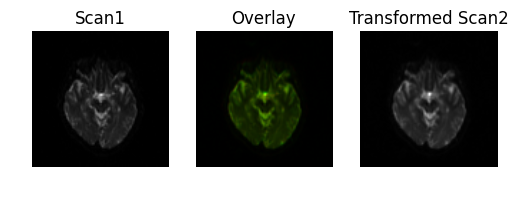

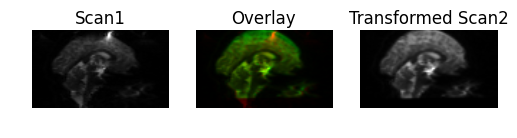

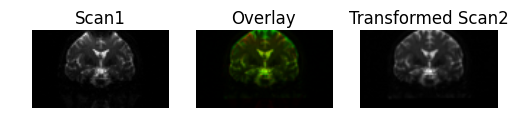

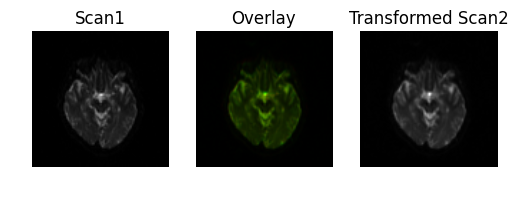

In [16]:
regtools.overlay_slices(dataScan1[:,:,:,0], scan2[:,:,:,0], None, 0, "Scan1", "Transformed Scan2")
regtools.overlay_slices(dataScan1[:,:,:,0], scan2[:,:,:,0], None, 1, "Scan1", "Transformed Scan2")
regtools.overlay_slices(dataScan1[:,:,:,0], scan2[:,:,:,0], None, 2, "Scan1", "Transformed Scan2")

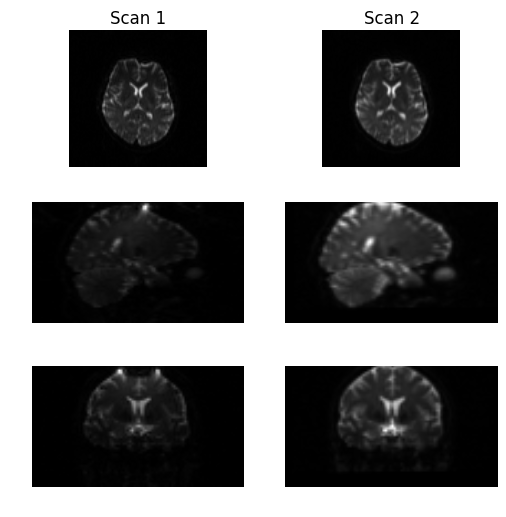

In [111]:
plot_chart(dataScan1, scan2, 40, 50, 34)

### Save the new transformed scan

In [117]:
transformed_Scan2 = nib.Nifti1Image(scan2.astype(np.float32), imgScan1.affine)
nib.save(transformed_Scan2, '/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan2/Transformed_Scan.nii.gz' )

### Compute brain masks for each scan

In [78]:
maskDataScan1, maskScan1 = median_otsu(dataScan1, 3, 3, autocrop=False, dilate=2)

maskDataScan2, maskScan2 = median_otsu(scan2, 3, 3, autocrop=False, dilate=2)

In [76]:
maskDataScan1.shape

(53, 61, 53, 117)

In [77]:
maskDataScan2.shape

(54, 62, 49, 117)

### Find the union of the masks

In [112]:
mask_union = np.logical_and(maskScan1, maskScan2)

### Apply the mask to the scans

In [113]:
scan1_brain = applymask(dataScan1, mask_union)
scan2_brain = applymask(scan2, mask_union)

### Crop the scans using the mask

In [115]:
#We need to get the bounding box of the mask_union 
(mins, maxs) = bounding_box(mask_union)

scan1_brain = crop(scan1_brain, mins, maxs)
scan2_brain = crop(scan2_brain, mins, maxs)

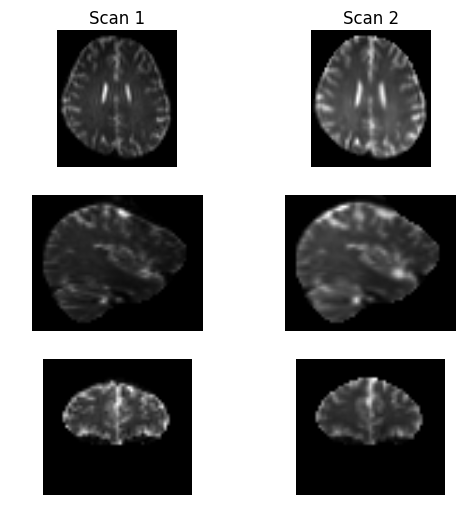

In [116]:
plot_chart(scan1_brain, scan2_brain, 40, 50, 34)

In [118]:
brainScan1 = nib.Nifti1Image(scan1_brain.astype(np.float32), imgScan1.affine)
nib.save(brainScan1, '/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan1/brain.nii.gz' )

brainScan2 = nib.Nifti1Image(scan2_brain.astype(np.float32), imgScan1.affine)
nib.save(brainScan2, '/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan2/brain.nii.gz' )